In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [2]:
# ETF 가격 데이터 다운로드
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
data = data.droplevel(0, axis=1).resample('M').last()

[*********************100%***********************]  9 of 9 completed
/var/folders/h1/6sllxx6j0zb6l_hvj_9ys3qh0000gn/T/ipykernel_77718/3270961402.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.droplevel(0, axis=1).resample('M').last()


In [3]:
# 수익률
ret = data.pct_change().dropna()

# 공분산 행렬
cov_mat = ret.cov() * 12

# 변동성
vols = ret.std() * np.sqrt(12)

In [12]:
cov_mat

Ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Ticker,,,,,,,,,
XLB,0.036702,0.035145,0.029631,0.030662,0.024191,0.014017,0.009905,0.018010,0.027772
XLE,0.035145,0.073340,0.036265,0.033267,0.022701,0.013510,0.007837,0.016948,0.026987
XLF,0.029631,0.036265,0.036034,0.029822,0.022375,0.012816,0.007957,0.016824,0.025556
XLI,0.030662,0.033267,0.029822,0.032161,0.023956,0.014507,0.009940,0.017294,0.026804
XLK,0.024191,0.022701,0.022375,0.023956,0.031097,0.012183,0.007954,0.014977,0.027579
XLP,0.014017,0.013510,0.012816,0.014507,0.012183,0.014302,0.010816,0.011308,0.012823
XLU,0.009905,0.007837,0.007957,0.009940,0.007954,0.010816,0.019949,0.008166,0.008530
XLV,0.018010,0.016948,0.016824,0.017294,0.014977,0.011308,0.008166,0.017918,0.016339
XLY,0.027772,0.026987,0.025556,0.026804,0.027579,0.012823,0.008530,0.016339,0.034021


In [11]:
vols

Ticker
XLB    0.191577
XLE    0.270813
XLF    0.189827
XLI    0.179334
XLK    0.176342
XLP    0.119592
XLU    0.141239
XLV    0.133858
XLY    0.184448
dtype: float64

In [4]:
# 고정 상관계수
corr_mat = ret.corr()

# 이것은 공분산 행열이 아니라 상관계수 행열을 만드는것. 
# 대각 행열은 다 상관계수가 1 일 것임. 자기상관 

# 대각 행열은 빼고, 나머지 삼각행열의 상관계수 평균
# corr_mat.sum().sum()  = 전체 상관계수 행열 을 다 더한다음.
# 티커의 캣수 만큼 빼 = 이렇게 하면 윗삼각, 아랫삼각 다 더한것 
# (len(corr_mat) ** 2 - len(corr_mat)) 는 전채 갯수 - 대각 행열 갯수 = 삼각 행열의 갯수들
const_corr = (corr_mat.sum().sum() - len(corr_mat)) / (len(corr_mat) ** 2 - len(corr_mat))
print(const_corr)

0.6096092627891758


In [5]:
corr_mat

Ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Ticker,,,,,,,,,
XLB,1.000000,0.677404,0.814800,0.892484,0.716075,0.611803,0.366073,0.702322,0.785940
XLE,0.677404,1.000000,0.705448,0.684995,0.475347,0.417144,0.204887,0.467533,0.540270
XLF,0.814800,0.705448,1.000000,0.876037,0.668416,0.564525,0.296762,0.662101,0.729889
XLI,0.892484,0.684995,0.876037,1.000000,0.757520,0.676420,0.392442,0.720434,0.810333
XLK,0.716075,0.475347,0.668416,0.757520,1.000000,0.577680,0.319340,0.634494,0.847910
XLP,0.611803,0.417144,0.564525,0.676420,0.577680,1.000000,0.640332,0.706359,0.581319
XLU,0.366073,0.204887,0.296762,0.392442,0.319340,0.640332,1.000000,0.431908,0.327430
XLV,0.702322,0.467533,0.662101,0.720434,0.634494,0.706359,0.431908,1.000000,0.661756
XLY,0.785940,0.540270,0.729889,0.810333,0.847910,0.581319,0.327430,0.661756,1.000000


In [6]:
# Shrinkage 방법을 적용한 공분산 행렬 계산
def covMatShrinkage(cov_mat, vols, const_corr, phi):  #phi가중치 

    # 자산 개수
    N = cov_mat.shape[0] 

    # 고정 상관계수로 상관계수 행렬 생성
    const_corr_mat = np.full((N, N), const_corr) # 우선 const_corr 로 채우고
    np.fill_diagonal(const_corr_mat, 1.0) # 대각 행열은 1.0으로 채우고

    # 자산별 변동성
    vols_mat = np.diag(vols) # vols를 대각 행열로 만드로 

    # 상관계수 행렬을 공분산 행렬로 변환
    const_cov_mat = vols_mat.T @ const_corr_mat @ vols_mat

    # 두 공분산 행렬을 블렌딩
    cov_mat_hat = (1 - phi) * cov_mat + phi * const_cov_mat

    # 업데이트된 공분산 행렬 반환
    return cov_mat_hat

In [7]:
# 가중치
phi = 0.7

# Shrinkage 방법을 적용한 새로운 공분산 행렬
cov_mat_hat = covMatShrinkage(cov_mat, vols, const_corr, phi)


In [13]:
cov_mat_hat

Ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Ticker,,,,,,,,,
XLB,0.036702,0.032683,0.024408,0.023859,0.021673,0.013982,0.014518,0.016346,0.023410
XLE,0.032683,0.073340,0.032817,0.030705,0.027189,0.017873,0.018673,0.020554,0.029411
XLF,0.024408,0.032817,0.036034,0.023474,0.020997,0.013532,0.013828,0.015890,0.022608
XLI,0.023859,0.030705,0.023474,0.032161,0.020682,0.013504,0.013791,0.015432,0.022156
XLK,0.021673,0.027189,0.020997,0.020682,0.031097,0.012654,0.013014,0.014566,0.022153
XLP,0.013982,0.017873,0.013532,0.013504,0.012654,0.014302,0.010453,0.010224,0.013260
XLU,0.014518,0.018673,0.013828,0.013791,0.013014,0.010453,0.019949,0.010517,0.013676
XLV,0.016346,0.020554,0.015890,0.015432,0.014566,0.010224,0.010517,0.017918,0.015437
XLY,0.023410,0.029411,0.022608,0.022156,0.022153,0.013260,0.013676,0.015437,0.034021


<Axes: xlabel='Ticker', ylabel='Ticker'>

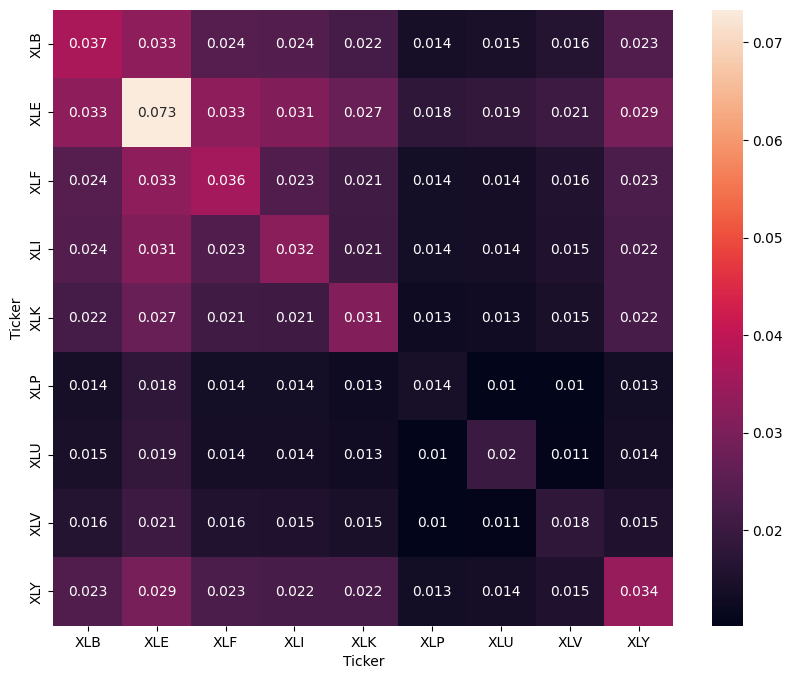

In [8]:
# 업데이트된 공분산 행렬 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(cov_mat_hat, annot=True)

<Axes: xlabel='Ticker', ylabel='Ticker'>

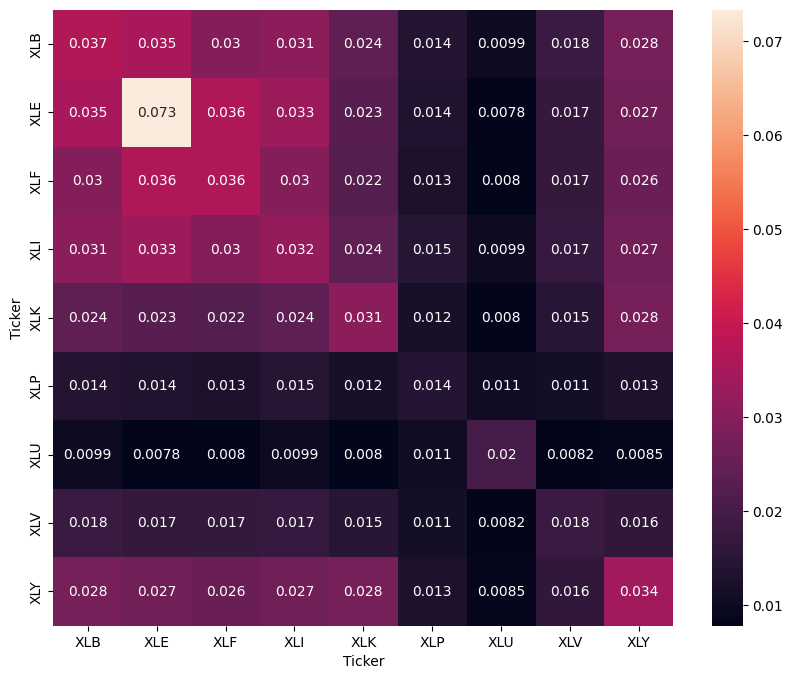

In [9]:
# 기존 공분산 행렬 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(cov_mat, annot=True)